# Problem 1: Naïve SIR

In [27]:
using DifferentialEquations, Plots, PlotThemes
theme(:juno)

In [2]:
function f!(du, u, p, t)
    """ Naïve SIR model """
    
    S, I = u
    γ, β = p
    
    du[1] = -β*S*I
    du[2] = β*S*I - γ*I   
    du[3] = γ*I
end

function solve_SIR(model, u0, p, tspan; kw...)
    """ 
    Solve the given model f with initial conditions
    u0, parameter vector p and tuple tspan.
    """
    
    problem = ODEProblem(model, u0, tspan, p)
    sol = solve(problem; kw...)

    return sol
end

function phase_plot(sol, vars; kw...)
    """ Create a phase plot of the given variables from
    the ODE solution sol. """
    
    plot(sol, vars=vars; kw...)
    
end

phase_plot (generic function with 1 method)

### Experiment 1.1: Epidemic

$$R_0 > 1$$

In [3]:
### population count and initial values ###
N = 100
S0 = 1
I0 = 1/N

### parameters to test for ###
γs = [0.1, 0.2, 0.4, 0.8]
βs = [0.3, 0.8, 2.4, 8.0]

u0 = [S0, I0, 0]
ps = [[γ, β] for (γ, β) in zip(γs, βs)]
tspan = (0.0, 40.0)

results = []

for p in ps
    sol = solve_SIR(f!, u0, p, tspan)
    push!(results, sol)
end

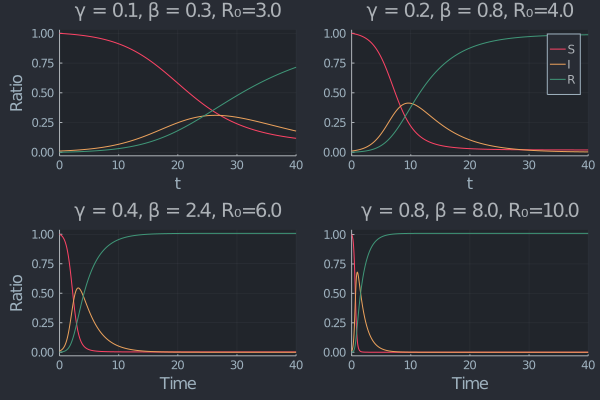

In [4]:
### plotting ###

labels = ["S" "I" "R"]
Rs = [1 .- sum(sir, dims=2) for sir in results] # recovered = N - (S + I)
R₀s = [p[2]/p[1] for p in ps]

p1 = plot(results[1], legend=false, title="γ = $(γs[1]), β = $(βs[1]), R₀=$(round(R₀s[1], digits=2))", ylabel="Ratio")
p2 = plot(results[2], label=labels, title="γ = $(γs[2]), β = $(βs[2]), R₀=$(round(R₀s[2], digits=2))")
p3 = plot(results[3], legend=false, title="γ = $(γs[3]), β = $(βs[3]), R₀=$(round(R₀s[3], digits=2))", xlabel="Time", ylabel="Ratio")
p4 = plot(results[4], legend=false, title="γ = $(γs[4]), β = $(βs[4]), R₀=$(round(R₀s[4], digits=2))", xlabel="Time")

plot(p1, p2, p3, p4, layout=4, titlefontsize=13)

### Experiment 1.2: No epidemic

In [5]:
### parameters to test for ###
βs = [0.19, 0.4, 0.4, 0.8]
γs = [0.2, 0.8, 2.4, 8.0]

I0 = 0.4
S0 = 0.6

u0 = [S0, I0, 0]
ps = [[γ, β] for (γ, β) in zip(γs, βs)]
tspan = (0.0, 40.0)

results = []

for p in ps
    sol = solve_SIR(f!, u0, p, tspan)
    push!(results, sol)
end

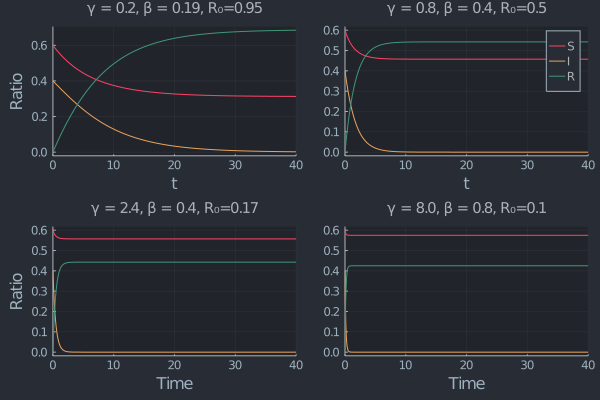

In [6]:
### Plotting ###
labels = ["S" "I" "R"]
Rs = [1 .- sum(sir, dims=2) for sir in results] # recovered = N - (S + I)
R₀s = [p[2]/p[1] for p in ps]

p1 = plot(results[1], legend=false, title="γ = $(γs[1]), β = $(βs[1]), R₀=$(round(R₀s[1], digits=2))", ylabel="Ratio")
p2 = plot(results[2], label=labels, title="γ = $(γs[2]), β = $(βs[2]), R₀=$(round(R₀s[2], digits=2))")
p3 = plot(results[3], legend=false, title="γ = $(γs[3]), β = $(βs[3]), R₀=$(round(R₀s[3], digits=2))", xlabel="Time", ylabel="Ratio")
p4 = plot(results[4], legend=false, title="γ = $(γs[4]), β = $(βs[4]), R₀=$(round(R₀s[4], digits=2))", xlabel="Time")

plot(p1, p2, p3, p4, layout=4, titlefontsize=10)

In [19]:
### phase space analysis ###

S0s = 0.4:0.1:1.0
I0 = 0.001

tspan = (0.0, 25.0)

p_ne = [0.4, 0.2] # no epidemic parameters
p_e = [1, 3]  # epidemic parameters

res_epid = []
res_no_epid = []

for S0 in S0s
    R0 = 1.0 - S0
    u0 = [S0, I0, R0]

    sir_e = solve_SIR(f!, u0, p_e, tspan)
    sir_ne = solve_SIR(f!, u0, p_ne, tspan)

    push!(res_epid, sir_e)
    push!(res_no_epid, sir_ne)
end


#I0 = 0.1
S0s = 0.1:0.1:1.0
for S0 in S0s
    I0 = 1.0 - S0
    u0 = [S0, I0, 0]

    sir_e = solve_SIR(f!, u0, p_e, tspan)
    sir_ne = solve_SIR(f!, u0, p_ne, tspan)

    push!(res_epid, sir_e)
    push!(res_no_epid, sir_ne)
end

In [13]:
βs = 0.1:0.5:10
#γs = 10:-0.5:0.1
γs = 0.1:0.5:10

u0 = [1.0, 0.01, 0.0]

maxI = zeros(length(βs), length(γs))
#p = plot()
for (i, β) in enumerate(βs)
    for (j, γ) in enumerate(γs)
        p = [γ, β]
        sol = solve_SIR(f!, u0, p, tspan)
        #push!(sols, sol)
        #plot!(p, sol, vars=(1, 2))
        maxI[i, j] = maximum(sol[2,:])
    end
end

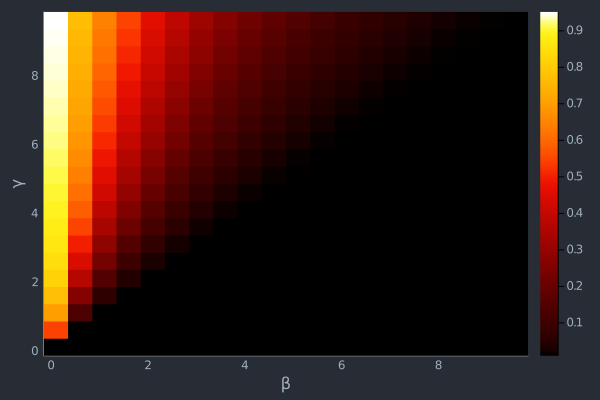

In [14]:
heatmap(βs, γs, maxI)
xlabel!("β")
ylabel!("γ")

In [62]:
begin
    default(size=(1200, 600))
    p1 = plot()#plot(res_epid[1], vars=(1, 2), legend=false)
    p2 = plot()#plot(res_no_epid[1], vars=(1, 2), legend=false)

    for i ∈ 1:length(res_epid)
        plot!(p1, res_epid[i], vars=(1, 2), legend=false)
        plot!(p2, res_no_epid[i], vars=(1, 2), legend=false)
        scatter!(p1, [res_epid[i][1,1]], [res_epid[i][2,1]], color=:red)
        scatter!(p2, [res_no_epid[i][1,1]], [res_no_epid[i][2,1]], color="red")
    end
    
    title!(p1, "Epidemic (R₀ > 1)")
    title!(p2, "No epidemic (R₀ < 1)")
    plot(p1, p2, xlabel="S", ylabel="I", xlims=[0, 1.0], ylims=[0, 1.0])#, size=(8, 16)) 
    #savefig("basic_phase.svg")
end
#plot!([0, 1], [1, 0], linestyle=:dashdot, linewidth=3, label="")

# Influenza Case

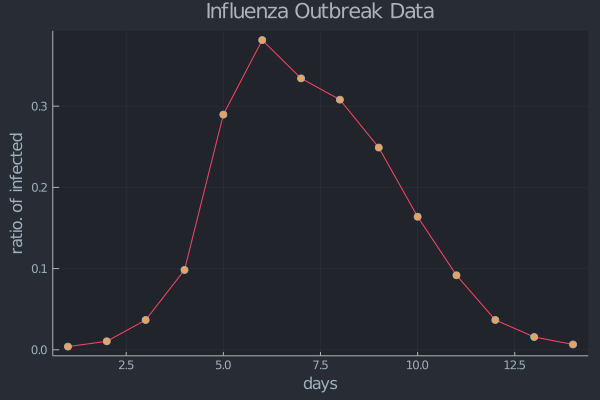

In [128]:
N = 763 # total number of students
days = 1:14 # duration of outbreak
cases = [3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5] ./ Ntotal # cases (ratio)

### plot the data ###
plot(days, cases, xlabel="days", ylabel="ratio. of infected", legend=false)
scatter!(days, cases, legend=false)
title!("Influenza Outbreak Data")


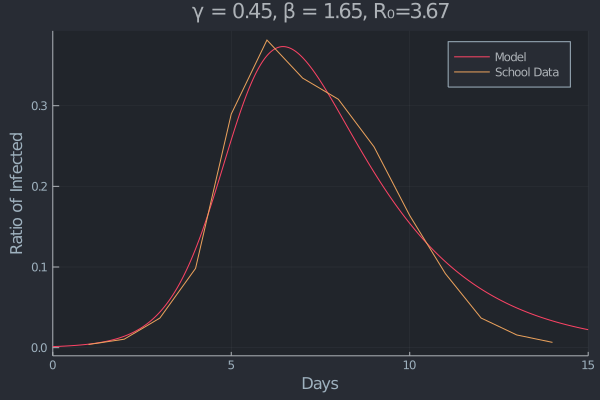

In [129]:

S0 = (N-1)/N # 
I0 = 1.0/N   # one person was initially infected
γ = 0.45
β = 1.65

u0 = [S0, I0, 0.0]
p = [γ, β]
tspan = (0.0, 15.0)

sol = solve_SIR(f!, u0, p, tspan)

plot(sol, vars=(0, 2), label="Model")#, yticks=cases)
plot!(days, cases, label="School Data")
ylabel!("Ratio of Infected")
xlabel!("Days")
title!("γ = $(p[1]), β = $(p[2]), R₀=$(round(β/γ, digits=2))")

#### Find the parameter values which best fit the model

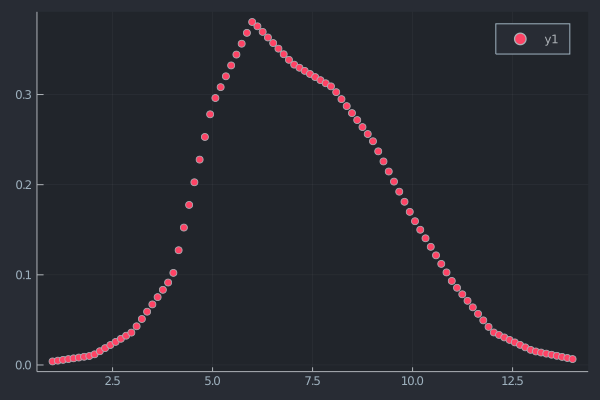

In [18]:
### get more data ###
using Interpolations
newdays = LinRange(1, 14, 100)

itp = interpolate(cases, BSpline(Linear()))
newcases = itp(newdays)
scatter(newdays, newcases)

Best parameter values: 
 
         γ =  0.48, 
 
         β =  1.95, 

         R₀ = 4.05 

         R² = 0.96


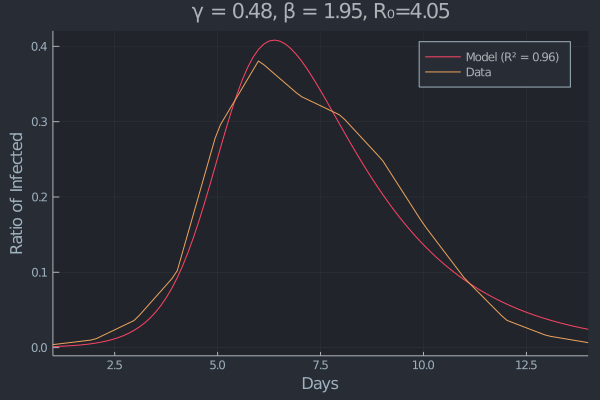

In [131]:
### find the best parameter by fitting a curve using Least-squares ###
using LsqFit

# interpolated data as x- and y-values #
xdata = newdays  
ydata = newcases
tspan = (1.0, 14.0)

model(x, pp) = solve_SIR(f!, u0, pp, tspan)(x)[2,:] # solve the SIR model and return the ratio of infected at the given time(s) x

p0 = [0.45, 1.65] # initial guess

fit = curve_fit(model, xdata, ydata, p0) # fit the model

### extract best parameter values and compute R₀ ###
bestγ = fit.param[1]
bestβ = fit.param[2]
R₀ = bestβ/bestγ

### call the model to get values for computing R² ###
ymodel = model(xdata, fit.param)

### compute R² of fit ###
SStot = sum((ydata .- sum(ydata)/length(ydata)).^2)  # sum of total squares
SSres = sum((ydata .- ymodel) .^ 2)                  # sum of residual squares
R² = 1.0 - SSres/SStot

println("Best parameter values: \n 
         γ =  $(round(bestγ, digits=2)), \n 
         β =  $(round(bestβ, digits=2)), \n
         R₀ = $(round(R₀, digits=2)) \n
         R² = $(round(R², digits=2))")

### visualize best fit ###

bestsol = solve_SIR(f!, u0, fit.param, tspan)

plot(bestsol, vars=(0, 2), plotdensity=length(xdata), label="Model (R² = $(round(R², digits=2)))")
plot!(xdata, ydata, label="Data")
xlabel!("Days")
ylabel!("Ratio of Infected")
title!("γ = $(round(bestγ, digits=2)), β = $(round(bestβ, digits=2)), R₀=$(round(R₀, digits=2))")

## Preventing the Epidemic with Vaccination

We will be able to prevent the epidemic if change in the infected ratio over time becomes negative.

$$\frac{dI(t)}{dt} < 0 $$

We introduce a vaccination term, which allows people to move directly from susceptibles to recovered. This means that our new equations are

$$S'= -\beta S I - f S$$

$$I' = \beta S I -\gamma I$$

$$R' = \gamma I + f S$$

So

$$I' < 0 \Rightarrow \beta S I - \gamma I < 0$$

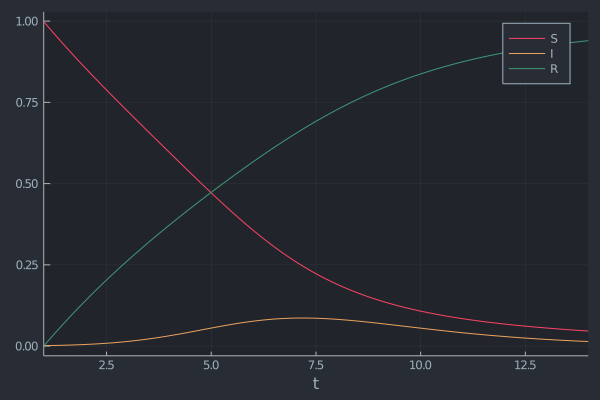

In [142]:
function fv!(du, u, p, t)
    """ Naive SIR with vaccination """
    
    S, I, R = u
    γ, β, ν = p
    
    du[1] = -β*S*I - ν*S
    du[2] = β*S*I - γ*I
    du[3] = γ*I + ν*S
    
end

p = [fit.param[1], fit.param[2], 0.15]
sol = solve_SIR(fv!, u0, p, tspan)

plot(sol, label=["S" "I" "R"])
#plot!(xdata, ydata)

# Problem 2: Demography: Birth and Death Rates

In [81]:
function f2!(du, u, p, t)
    """ 
    SIR with birth and natural death rates
    """
    
    S, I, R = u
    γ, β, μ = p
    
    du[1] = -β*S*I + μ - μ*S
    du[2] = β*S*I - γ*I - μ*I
    du[3] = γ*I - μ*R
    
end

f2! (generic function with 1 method)

### 2.1: How do the dynamics change?

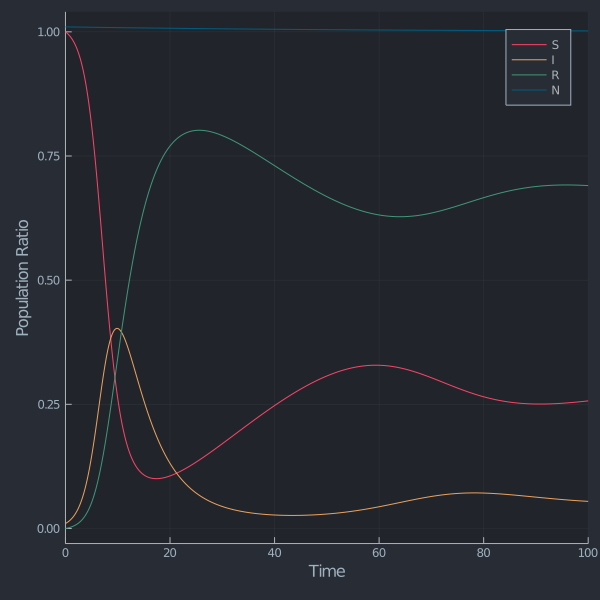

In [82]:
S0 = 1.0
I0 = 1e-2

γ = 0.2
β = 0.8
μ = 1/60

u0 = [S0, I0, 0]
p = [γ, β, μ]

tspan = (0, 100.0)

sol = solve_SIR(f2!, u0, p, tspan);

plot(sol, labels=["S" "I" "R"])
plot!(sol.t, sum(sol, dims=1)', label="N")
xlabel!("Time")
ylabel!("Population Ratio")

### 2.2: Capturing an Endemic State

In [83]:
S0 = 0.1
I0 = 2.5e-4
R0 = 1 .- (S0 + I0)

γ = 52
β = 520
μ = 1/70

u0 = [S0, I0, R0]
p = [γ, β, μ]

tspan = (0, 300.0)

sir = solve_SIR(f2!, u0, p, tspan);

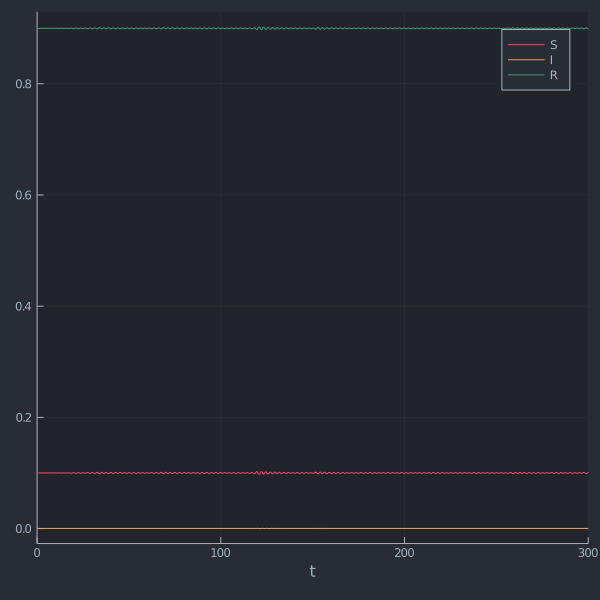

In [84]:
plot(sir, label=[labels "R"])
#plot!(t, sum(sir, dims=2), label="N")

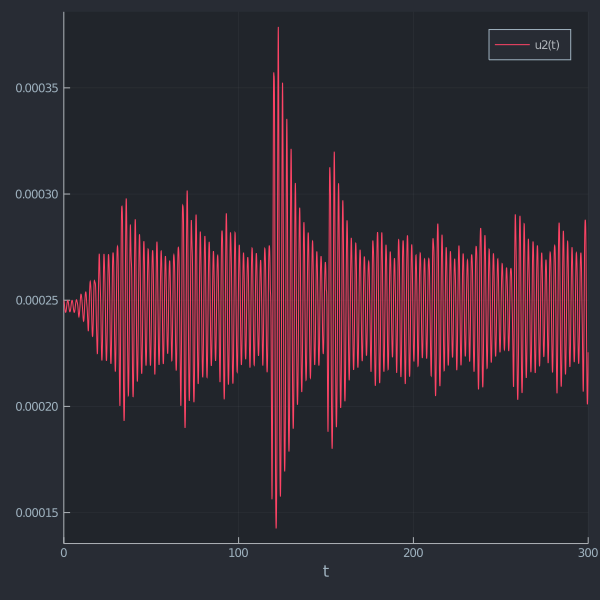

In [91]:
plot(sir, vars=(0, 2))#, tspan=(0, 10))

In [86]:
### fourier analysis ###
using FFTW

In [87]:
I = @view sir[2,:]

ff = abs.(fft(I));

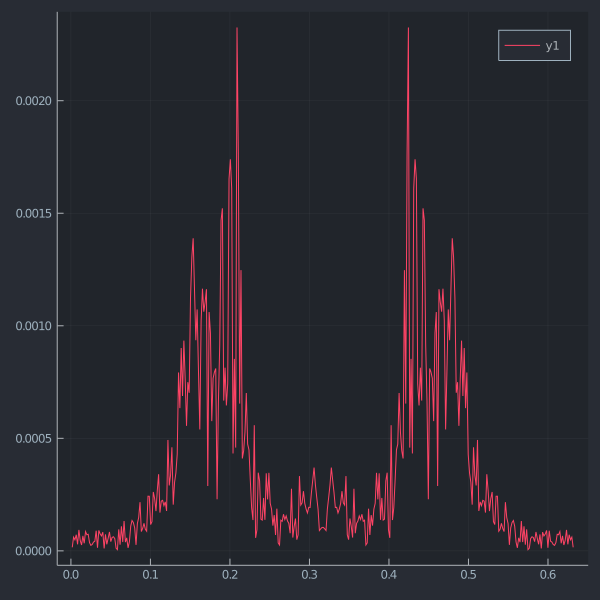

In [88]:
Nsamples = length(I)
sample_rate = Nsamples/tspan[2] # Nyquist-Shannon Sampling theorem

x = LinRange(0, sample_rate/2, length(ff))
plot(x[2:end], ff[2:end])

## 2.2: Adding Death from Infection

In [92]:
function f3!(du, u, p, t)
    """ SIR model with natural birth and death, and death from infection """
    
    N = sum(u)
    S, I, R = u
    γ, β, μ, η = p
    
    du[1] = -β*S*I/N + μ*N - μ*S
    du[2] =  β*S*I/N - γ*I - μ*I - η*I
    du[3] =  γ*I - μ*R
    
end

f3! (generic function with 1 method)

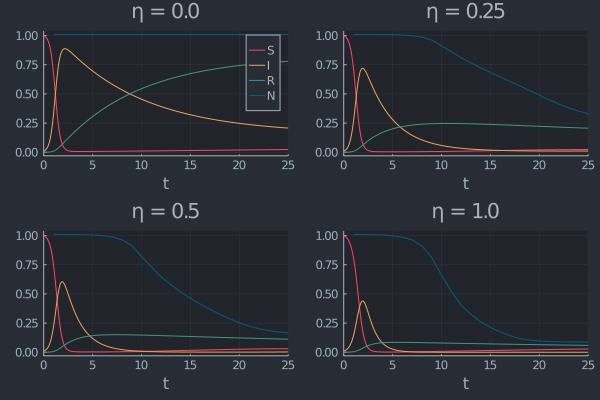

In [109]:
N = 100

S0 = 1.0
I0 = 1.0/N
γ = 0.1
β = 4
μ = 1/50
ηs = [0.0, 0.25, 0.5, 1.0]

u0 = [S0, I0, 0]
tspan = (0.0, 25)

results = []
for η in ηs
    p = [γ, β, μ, η]
    sol = solve_SIR(f3!, u0, p, tspan);
    push!(results, sol)
end

labels = ["S" "I" "R"]
p1 = plot(results[1], title="η = $(ηs[1])", label=labels)
p2 = plot(results[2], title="η = $(ηs[2])", legend=false)
p3 = plot(results[3], title="η = $(ηs[3])", legend=false)
p4 = plot(results[4], title="η = $(ηs[4])", legend=false)

plot!(p1, sum(results[1], dims=1)', label="N")
plot!(p2, sum(results[2], dims=1)', legend=false)
plot!(p3, sum(results[3], dims=1)', legend=false)
plot!(p4, sum(results[4], dims=1)', legend=false)

plot(p1, p2, p3, p4)

# Problem 3: Variation: The SEIRS Model



In [92]:
function SEIRS!(du, u, p, t)
       
    N = sum(u)
    S, E, I, R = u
    γ, β₀, σ, Ω, η, μ, ω, A = p
    
    β = A*cos(ω*t) + β₀ # seasonal variation
    
    du[1] = -β*S*I/N - μ*S + μ*N + Ω*R #S: -infection - death + birth + immunity loss
    du[2] = β*S*I/N - (σ + μ)*E        #E: infection - latency - natural death 
    du[3] = σ*E - (γ + μ + η)*I        #I: latency - recovery - natural death - death from illness
    du[4] = γ*I - Ω*R - μ*R            #R: recovery - immunity loss - natural death  
end

R0_SEIRS(σ, μ, β, η) = σ/(σ + μ)*β/(σ + μ + η)

R0_SEIRS (generic function with 1 method)

In [109]:
β₀ = 75   # average rate of transmission
A = 0.5*β₀    # maximum deviation from β₀
ω = 10    # frequenecy of transmission oscillation
σ = 10  # latency
γ = 3    # recovery rate
Ω = 0.4    # immunity loss
η = 0.3    # death from infection
μ = 1/76   # birth and natural death

R₀ = R0_SEIRS(σ, μ, β, η)

println(R₀)

S0 = 0.8
E0 = 0.2
R0 = 0
I0 = 0



u0 = [S0, E0, I0, R0]
p = [γ, β₀, σ, Ω, η, μ, ω, A]


tspan = (0, 5.0)

sol = solve_SIR(SEIRS!, u0, p, tspan);

50.35476949622764


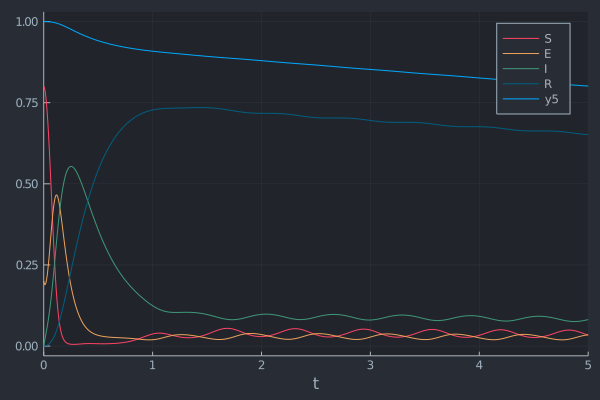

In [110]:
plot(sol, label=["S" "E" "I" "R"])
plot!(sol.t, sum(sol, dims=1)')

In [111]:
### phase space analysis ###

S0s = 0.4:0.1:1.0
E0 = 0.001

tspan = (0.0, 20.0)

p = [γ, β₀, σ, Ω, η, μ, ω, A]

result = []
#res_no_epid = []

for S0 in S0s
    R0 = 1.0 - S0
    u0 = [S0, E0, 0, R0]

    sir_e = solve_SIR(SEIRS!, u0, p, tspan)
    #sir_ne = solve_SIR(f!, u0, p_ne, tspan)

    push!(result, sir_e)
    #push!(res_no_epid, sir_ne)
end


#I0 = 0.1
S0s = 0.1:0.1:1.0
for S0 in S0s
    E0 = 1.0 - S0
    u0 = [S0, E0, 0, 0]

    sir_e = solve_SIR(SEIRS!, u0, p, tspan)
    #sir_ne = solve_SIR(f!, u0, p_ne, tspan)

    push!(result, sir_e)
    #push!(res_no_epid, sir_ne)
end

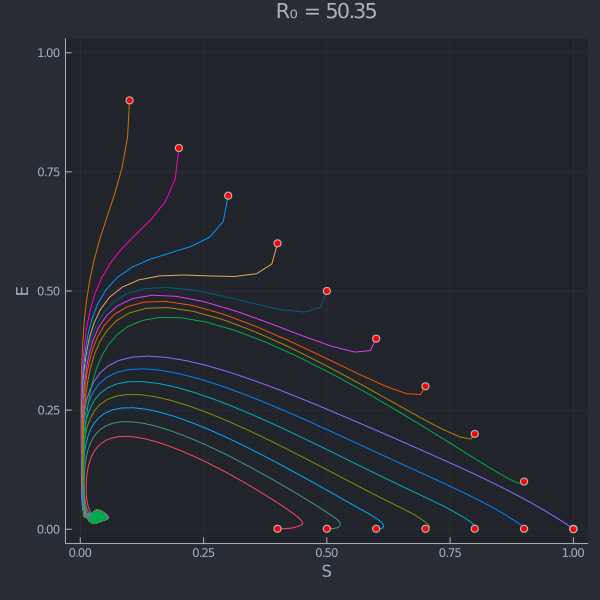

In [112]:
default(size=(600, 600))
p1 = plot()#plot(res_epid[1], vars=(1, 2), legend=false)

for i ∈ 1:length(result)
    plot!(p1, result[i], vars=(1, 2), legend=false)
    scatter!(p1, [result[i][1,1]], [result[i][2,1]], color=:red)
end

title!(p1, "R₀ = $(round(R₀, digits=2))")
plot(p1, xlabel="S", ylabel="E", xlims=[0, 1.0], ylims=[0, 1.0])#, size=(8, 16)) 

#savefig("seirs_phase.svg")
p1